In [1]:
import sys
import os
from pathlib import Path
from multiprocessing import cpu_count, Pool

import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall

import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [2]:
RAW_PATH = "../TIM-Net_SER/Code/RawData"
THREADS = 50

## Load Data

In [3]:
df_train_map = pd.read_csv(os.path.join(RAW_PATH, 'train_data.csv'))
df_test_map = pd.read_csv(os.path.join(RAW_PATH, 'test_data.csv'))
df_train_map['name'] = df_train_map['name'].str.replace('.mp4', '.wav', regex=False)
df_test_map['name'] = df_test_map['name'].str.replace('.mp4', '.wav', regex=False)

lbec = LabelEncoder().fit(df_train_map['emotion'])
df_train_map['emotion'] = lbec.transform(df_train_map['emotion'])
df_test_map['emotion'] = lbec.transform(df_test_map['emotion'])
print(lbec.classes_)

ohec = OneHotEncoder().fit(df_train_map[['emotion']])
train_y = ohec.transform(df_train_map[['emotion']]).toarray()
test_y = ohec.transform(df_test_map[['emotion']]).toarray()
print(ohec.categories_)
# lbec.inverse_transform()

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
[array([0, 1, 2, 3, 4, 5, 6, 7])]


In [4]:
df_train_map['fullpath'] = RAW_PATH + '/' + df_train_map['source'] + '/' + df_train_map['name']
df_test_map['fullpath'] = RAW_PATH + '/' + df_test_map['source'] + '/' + df_test_map['name']
ls_train_fullpath = df_train_map['fullpath'].tolist()
ls_test_fullpath = df_test_map['fullpath'].tolist()

## Feature Extraction

In [5]:
def extract_features(filepath):
    data, sample_rate = librosa.load(filepath)
    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    
    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stf = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)

    result = np.hstack((zcr, chroma_stf, mfcc, rms, mel))
    return result

In [6]:
pool = Pool(THREADS)
train_X = list(tqdm(pool.imap(extract_features, ls_train_fullpath), total=len(ls_train_fullpath)))
train_X = np.array(train_X)
test_X = list(tqdm(pool.imap(extract_features, ls_test_fullpath), total=len(ls_test_fullpath)))
test_X = np.array(test_X)

100%|██████████| 5078/5078 [03:25<00:00, 24.75it/s]


In [9]:
np.save('features/MERGE_TRAIN_BASELINE.npy', {'x': train_X, 'y': train_y}, allow_pickle=True)
np.save('features/MERGE_TEST_BASELINE.npy', {'x': test_X, 'y': test_y}, allow_pickle=True)

## Data Preprocessing

In [12]:
print(f"{'Train X Shape':<15}: {train_X.shape}")
print(f"{'Train y Shape':<15}: {train_y.shape}")

print(f"{'Test X Shape':<15}: {test_X.shape}")
print(f"{'Test y Shape':<15}: {test_y.shape}")

Train X Shape  : (20310, 162)
Train y Shape  : (20310, 8)
Test X Shape   : (5078, 162)
Test y Shape   : (5078, 8)


In [13]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

train_X = np.expand_dims(train_X, axis=2)
test_X = np.expand_dims(test_X, axis=2)

## Model

In [41]:
BATCH_SIZE = 256
EPOCHS = 120
LR = 1e-4

In [42]:
def get_SER_model():
    model = Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(train_X.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(units=8, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(lr=LR)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

    print(model.summary())

    return model

model = get_SER_model()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 162, 256)          1536      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 81, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 81, 256)           327936    
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 41, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 21, 128)         

In [43]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=1e-7)
ckpt = ModelCheckpoint('checkpoint', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
history = model.fit(train_X, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_X, test_y), callbacks=[rlrp, ckpt])

Epoch 1/120
77/80 [===========================>..] - ETA: 0s - loss: 1.8829 - accuracy: 0.3074 - precision_3: 0.5006 - recall_3: 0.0222
Epoch 1: val_loss improved from inf to 1.70276, saving model to chekcpoint


INFO:tensorflow:Assets written to: chekcpoint/assets


INFO:tensorflow:Assets written to: chekcpoint/assets


80/80 [==============================] - 5s 34ms/step - loss: 1.8794 - accuracy: 0.3099 - precision_3: 0.5059 - recall_3: 0.0232 - val_loss: 1.7028 - val_accuracy: 0.3937 - val_precision_3: 0.6036 - val_recall_3: 0.0201 - lr: 0.0010
Epoch 2/120
79/80 [============================>.] - ETA: 0s - loss: 1.7020 - accuracy: 0.3847 - precision_3: 0.5522 - recall_3: 0.0920
Epoch 2: val_loss improved from 1.70276 to 1.63408, saving model to chekcpoint


INFO:tensorflow:Assets written to: chekcpoint/assets


INFO:tensorflow:Assets written to: chekcpoint/assets


80/80 [==============================] - 2s 30ms/step - loss: 1.7015 - accuracy: 0.3850 - precision_3: 0.5533 - recall_3: 0.0925 - val_loss: 1.6341 - val_accuracy: 0.4072 - val_precision_3: 0.5373 - val_recall_3: 0.1944 - lr: 0.0010
Epoch 3/120
77/80 [===========================>..] - ETA: 0s - loss: 1.6193 - accuracy: 0.4085 - precision_3: 0.5995 - recall_3: 0.1392
Epoch 3: val_loss improved from 1.63408 to 1.54849, saving model to chekcpoint


INFO:tensorflow:Assets written to: chekcpoint/assets


INFO:tensorflow:Assets written to: chekcpoint/assets


80/80 [==============================] - 3s 35ms/step - loss: 1.6197 - accuracy: 0.4084 - precision_3: 0.5998 - recall_3: 0.1387 - val_loss: 1.5485 - val_accuracy: 0.4421 - val_precision_3: 0.7610 - val_recall_3: 0.0853 - lr: 0.0010
Epoch 4/120
80/80 [==============================] - ETA: 0s - loss: 1.5743 - accuracy: 0.4235 - precision_3: 0.6203 - recall_3: 0.1562
Epoch 4: val_loss improved from 1.54849 to 1.50176, saving model to chekcpoint


INFO:tensorflow:Assets written to: chekcpoint/assets


INFO:tensorflow:Assets written to: chekcpoint/assets


80/80 [==============================] - 2s 27ms/step - loss: 1.5743 - accuracy: 0.4235 - precision_3: 0.6203 - recall_3: 0.1562 - val_loss: 1.5018 - val_accuracy: 0.4455 - val_precision_3: 0.7320 - val_recall_3: 0.1199 - lr: 0.0010
Epoch 5/120
75/80 [===========================>..] - ETA: 0s - loss: 1.5328 - accuracy: 0.4398 - precision_3: 0.6319 - recall_3: 0.1660
Epoch 5: val_loss improved from 1.50176 to 1.46662, saving model to chekcpoint


INFO:tensorflow:Assets written to: chekcpoint/assets


INFO:tensorflow:Assets written to: chekcpoint/assets


80/80 [==============================] - 2s 27ms/step - loss: 1.5345 - accuracy: 0.4398 - precision_3: 0.6304 - recall_3: 0.1662 - val_loss: 1.4666 - val_accuracy: 0.4728 - val_precision_3: 0.6517 - val_recall_3: 0.1835 - lr: 0.0010
Epoch 6/120
79/80 [============================>.] - ETA: 0s - loss: 1.5020 - accuracy: 0.4497 - precision_3: 0.6427 - recall_3: 0.1800
Epoch 6: val_loss improved from 1.46662 to 1.45523, saving model to chekcpoint


INFO:tensorflow:Assets written to: chekcpoint/assets


INFO:tensorflow:Assets written to: chekcpoint/assets


80/80 [==============================] - 2s 29ms/step - loss: 1.5017 - accuracy: 0.4499 - precision_3: 0.6424 - recall_3: 0.1798 - val_loss: 1.4552 - val_accuracy: 0.4874 - val_precision_3: 0.8187 - val_recall_3: 0.1138 - lr: 0.0010
Epoch 7/120
78/80 [============================>.] - ETA: 0s - loss: 1.4765 - accuracy: 0.4596 - precision_3: 0.6519 - recall_3: 0.2011
Epoch 7: val_loss improved from 1.45523 to 1.45246, saving model to chekcpoint


INFO:tensorflow:Assets written to: chekcpoint/assets


INFO:tensorflow:Assets written to: chekcpoint/assets


80/80 [==============================] - 3s 32ms/step - loss: 1.4758 - accuracy: 0.4597 - precision_3: 0.6530 - recall_3: 0.2005 - val_loss: 1.4525 - val_accuracy: 0.4850 - val_precision_3: 0.8402 - val_recall_3: 0.1128 - lr: 0.0010
Epoch 8/120
77/80 [===========================>..] - ETA: 0s - loss: 1.4476 - accuracy: 0.4688 - precision_3: 0.6628 - recall_3: 0.2050
Epoch 8: val_loss improved from 1.45246 to 1.41153, saving model to chekcpoint


INFO:tensorflow:Assets written to: chekcpoint/assets


INFO:tensorflow:Assets written to: chekcpoint/assets


80/80 [==============================] - 2s 25ms/step - loss: 1.4484 - accuracy: 0.4686 - precision_3: 0.6612 - recall_3: 0.2055 - val_loss: 1.4115 - val_accuracy: 0.4858 - val_precision_3: 0.6681 - val_recall_3: 0.2212 - lr: 0.0010
Epoch 9/120
74/80 [==========================>...] - ETA: 0s - loss: 1.4273 - accuracy: 0.4781 - precision_3: 0.6708 - recall_3: 0.2185
Epoch 9: val_loss improved from 1.41153 to 1.40521, saving model to chekcpoint


INFO:tensorflow:Assets written to: chekcpoint/assets


INFO:tensorflow:Assets written to: chekcpoint/assets


80/80 [==============================] - 2s 29ms/step - loss: 1.4303 - accuracy: 0.4777 - precision_3: 0.6684 - recall_3: 0.2175 - val_loss: 1.4052 - val_accuracy: 0.4888 - val_precision_3: 0.8166 - val_recall_3: 0.1298 - lr: 0.0010
Epoch 10/120
76/80 [===========================>..] - ETA: 0s - loss: 1.4171 - accuracy: 0.4840 - precision_3: 0.6772 - recall_3: 0.2187
Epoch 10: val_loss improved from 1.40521 to 1.37649, saving model to chekcpoint


INFO:tensorflow:Assets written to: chekcpoint/assets


INFO:tensorflow:Assets written to: chekcpoint/assets


80/80 [==============================] - 2s 30ms/step - loss: 1.4163 - accuracy: 0.4839 - precision_3: 0.6794 - recall_3: 0.2202 - val_loss: 1.3765 - val_accuracy: 0.4994 - val_precision_3: 0.7104 - val_recall_3: 0.2121 - lr: 0.0010
Epoch 11/120
76/80 [===========================>..] - ETA: 0s - loss: 1.4116 - accuracy: 0.4844 - precision_3: 0.6761 - recall_3: 0.2225
Epoch 11: val_loss did not improve from 1.37649
80/80 [==============================] - 1s 12ms/step - loss: 1.4110 - accuracy: 0.4852 - precision_3: 0.6751 - recall_3: 0.2221 - val_loss: 1.3899 - val_accuracy: 0.4951 - val_precision_3: 0.6701 - val_recall_3: 0.2460 - lr: 0.0010
Epoch 12/120
80/80 [==============================] - ETA: 0s - loss: 1.3904 - accuracy: 0.4903 - precision_3: 0.6791 - recall_3: 0.2299
Epoch 12: val_loss did not improve from 1.37649
80/80 [==============================] - 1s 13ms/step - loss: 1.3904 - accuracy: 0.4903 - precision_3: 0.6791 - recall_3: 0.2299 - val_loss: 1.3777 - val_accuracy: 

INFO:tensorflow:Assets written to: chekcpoint/assets


INFO:tensorflow:Assets written to: chekcpoint/assets


80/80 [==============================] - 2s 30ms/step - loss: 1.3735 - accuracy: 0.4993 - precision_3: 0.6955 - recall_3: 0.2402 - val_loss: 1.3722 - val_accuracy: 0.5104 - val_precision_3: 0.8408 - val_recall_3: 0.1445 - lr: 0.0010
Epoch 14/120
77/80 [===========================>..] - ETA: 0s - loss: 1.3666 - accuracy: 0.5013 - precision_3: 0.6980 - recall_3: 0.2479
Epoch 14: val_loss improved from 1.37219 to 1.35785, saving model to chekcpoint


INFO:tensorflow:Assets written to: chekcpoint/assets


INFO:tensorflow:Assets written to: chekcpoint/assets


80/80 [==============================] - 3s 35ms/step - loss: 1.3656 - accuracy: 0.5008 - precision_3: 0.6988 - recall_3: 0.2475 - val_loss: 1.3579 - val_accuracy: 0.5108 - val_precision_3: 0.7590 - val_recall_3: 0.1904 - lr: 0.0010
Epoch 15/120
78/80 [============================>.] - ETA: 0s - loss: 1.3562 - accuracy: 0.5011 - precision_3: 0.7016 - recall_3: 0.2509
Epoch 15: val_loss improved from 1.35785 to 1.35045, saving model to chekcpoint


INFO:tensorflow:Assets written to: chekcpoint/assets


INFO:tensorflow:Assets written to: chekcpoint/assets


80/80 [==============================] - 2s 29ms/step - loss: 1.3559 - accuracy: 0.5015 - precision_3: 0.7009 - recall_3: 0.2514 - val_loss: 1.3504 - val_accuracy: 0.5116 - val_precision_3: 0.6738 - val_recall_3: 0.2733 - lr: 0.0010
Epoch 16/120
78/80 [============================>.] - ETA: 0s - loss: 1.3490 - accuracy: 0.5069 - precision_3: 0.7048 - recall_3: 0.2511
Epoch 16: val_loss did not improve from 1.35045
80/80 [==============================] - 1s 12ms/step - loss: 1.3473 - accuracy: 0.5075 - precision_3: 0.7053 - recall_3: 0.2518 - val_loss: 1.3704 - val_accuracy: 0.5006 - val_precision_3: 0.6288 - val_recall_3: 0.3106 - lr: 0.0010
Epoch 17/120
76/80 [===========================>..] - ETA: 0s - loss: 1.3380 - accuracy: 0.5098 - precision_3: 0.6956 - recall_3: 0.2686
Epoch 17: val_loss did not improve from 1.35045
80/80 [==============================] - 1s 12ms/step - loss: 1.3388 - accuracy: 0.5091 - precision_3: 0.6969 - recall_3: 0.2671 - val_loss: 1.3636 - val_accuracy: 

INFO:tensorflow:Assets written to: chekcpoint/assets


INFO:tensorflow:Assets written to: chekcpoint/assets


80/80 [==============================] - 2s 31ms/step - loss: 1.3354 - accuracy: 0.5115 - precision_3: 0.7047 - recall_3: 0.2604 - val_loss: 1.3490 - val_accuracy: 0.5041 - val_precision_3: 0.7060 - val_recall_3: 0.2322 - lr: 0.0010
Epoch 19/120
76/80 [===========================>..] - ETA: 0s - loss: 1.3242 - accuracy: 0.5154 - precision_3: 0.6959 - recall_3: 0.2712
Epoch 19: val_loss improved from 1.34897 to 1.33649, saving model to chekcpoint


INFO:tensorflow:Assets written to: chekcpoint/assets


INFO:tensorflow:Assets written to: chekcpoint/assets


80/80 [==============================] - 2s 29ms/step - loss: 1.3258 - accuracy: 0.5153 - precision_3: 0.6977 - recall_3: 0.2691 - val_loss: 1.3365 - val_accuracy: 0.5161 - val_precision_3: 0.7512 - val_recall_3: 0.2152 - lr: 0.0010
Epoch 20/120
75/80 [===========================>..] - ETA: 0s - loss: 1.3219 - accuracy: 0.5182 - precision_3: 0.7024 - recall_3: 0.2737
Epoch 20: val_loss did not improve from 1.33649
80/80 [==============================] - 1s 13ms/step - loss: 1.3202 - accuracy: 0.5190 - precision_3: 0.7054 - recall_3: 0.2740 - val_loss: 1.3609 - val_accuracy: 0.5028 - val_precision_3: 0.7321 - val_recall_3: 0.2158 - lr: 0.0010
Epoch 21/120
79/80 [============================>.] - ETA: 0s - loss: 1.3109 - accuracy: 0.5204 - precision_3: 0.7142 - recall_3: 0.2726
Epoch 21: val_loss did not improve from 1.33649
80/80 [==============================] - 1s 13ms/step - loss: 1.3102 - accuracy: 0.5209 - precision_3: 0.7145 - recall_3: 0.2730 - val_loss: 1.3464 - val_accuracy: 

INFO:tensorflow:Assets written to: chekcpoint/assets


INFO:tensorflow:Assets written to: chekcpoint/assets


80/80 [==============================] - 2s 31ms/step - loss: 1.2989 - accuracy: 0.5246 - precision_3: 0.7106 - recall_3: 0.2838 - val_loss: 1.3321 - val_accuracy: 0.5118 - val_precision_3: 0.7267 - val_recall_3: 0.2383 - lr: 0.0010
Epoch 23/120
80/80 [==============================] - ETA: 0s - loss: 1.2908 - accuracy: 0.5261 - precision_3: 0.7150 - recall_3: 0.2879
Epoch 23: val_loss did not improve from 1.33210
80/80 [==============================] - 1s 14ms/step - loss: 1.2908 - accuracy: 0.5261 - precision_3: 0.7150 - recall_3: 0.2879 - val_loss: 1.3340 - val_accuracy: 0.5146 - val_precision_3: 0.7069 - val_recall_3: 0.2617 - lr: 0.0010
Epoch 24/120
76/80 [===========================>..] - ETA: 0s - loss: 1.2823 - accuracy: 0.5297 - precision_3: 0.7186 - recall_3: 0.2908
Epoch 24: val_loss did not improve from 1.33210
80/80 [==============================] - 1s 14ms/step - loss: 1.2821 - accuracy: 0.5298 - precision_3: 0.7207 - recall_3: 0.2906 - val_loss: 1.3344 - val_accuracy: 

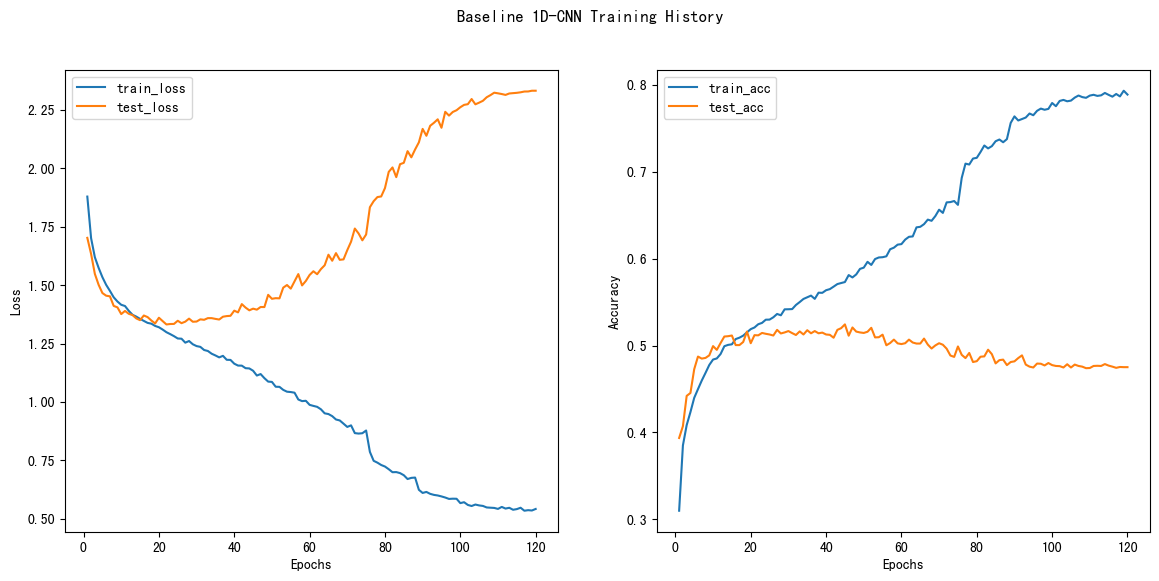

In [44]:
history.history.keys()
def plot_loss(history, model_name):
    history = history.history
    train_loss, train_acc = history['loss'], history['accuracy']
    test_loss, test_acc = history['val_loss'], history['val_accuracy']
    epoch = list(range(1, EPOCHS+1))

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    plt.suptitle(f'{model_name} Training History')
    axes[0].plot(epoch, train_loss, label='train_loss')
    axes[0].plot(epoch, test_loss, label='test_loss')
    axes[0].set_xlabel('Epochs'), axes[0].set_ylabel('Loss'), axes[0].legend()

    axes[1].plot(epoch, train_acc, label='train_acc')
    axes[1].plot(epoch, test_acc, label='test_acc')
    axes[1].set_xlabel('Epochs'), axes[1].set_ylabel('Accuracy'), axes[1].legend()

plot_loss(history, 'Baseline 1D-CNN')

In [46]:
from tensorflow.keras.models import load_model
model = load_model('checkpoint')
pred_y = model.predict(test_X)
pred_y_in = ohec.inverse_transform(pred_y)
test_y_in = ohec.inverse_transform(test_y)
print(classification_report(test_y_in, pred_y_in, target_names=lbec.classes_))

159/159 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

       angry       0.71      0.34      0.46       694
        calm       0.48      0.61      0.53        38
     disgust       0.54      0.31      0.40       445
        fear       0.64      0.41      0.50       444
       happy       0.51      0.25      0.33       834
     neutral       0.47      0.92      0.62      1604
         sad       0.56      0.41      0.47       573
    surprise       0.61      0.24      0.35       446

    accuracy                           0.51      5078
   macro avg       0.56      0.43      0.46      5078
weighted avg       0.55      0.51      0.48      5078



['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Text(85.22222222222221, 0.5, 'Actual Labels')

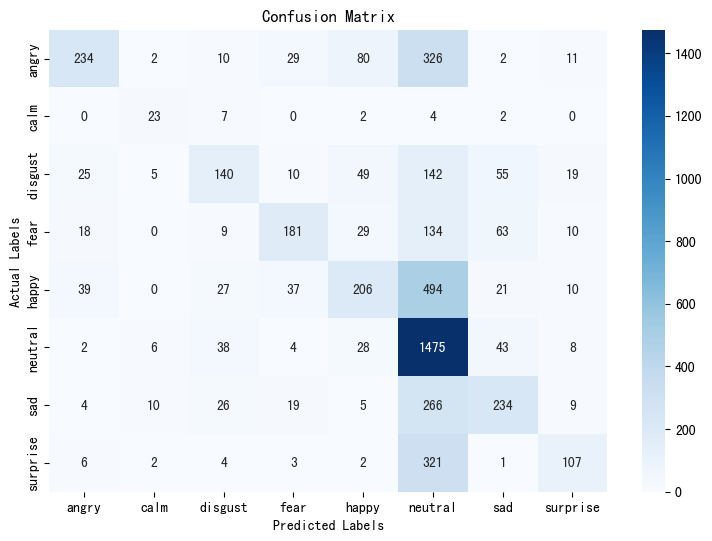

In [57]:
cm = pd.DataFrame(confusion_matrix(test_y_in, pred_y_in), index=[i for i in lbec.classes_], columns=[i for i in lbec.classes_])

fig, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(cm, linecolor='white', cmap='Blues', annot=True, ax=ax, fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')